# Instrument Delays

*It makes sense to read [Boat Instruments](Boat_Instruments.ipynb) if you do not yet know about the set of all instruments on a modern boat and how that data is processed.*

Various physical phenomena are measured using instruments on the boat and captured in different ways.  As we have already discussed, the raw signals can be quite noisy, and many of the signals are "damped" (i.e. filtered) before they are displayed (AWA, AWS, SPD, etc).  Other signals are computed from basic instruments (TWD, TWA, etc).  Damped/filtered signals are typically delayed.

The most complex instrument by far is the GPS, which provides speed and course over ground (SOG and COG).  GPS uses the ranges measured to 5-10 satellites to triangulate the position on the earth.  The process of tracking the satellites and estimating distance is complex (and it requires filtering).  From that positions and velocities are estimated, which in turn requires filtering.  

All this filtering adds up to some delay.  The question is **how much delay**?

## Summary

In this notebook, we will compare COG and the HDG and search for a latency that best aligns the two values (being sure to first realize that HDG is magnetic north and not true north).  Note, on any given day, for any given race, we might run into some issues with this approach.  If the current is strong out of the north (flood here in Seattle) and we are sailing East to West, then the COG will always be south of the HDG.  Our hope is that this will wash out for an entire sailing session.  And it should certainly wash out across many days.

## Glossary

- AWA: apparent wind angle, the angle of the wind blowing at the top the mast (fast but noisy)
- AWS: apparent wind speed, the speed at the mast head (fast and noisy)
- SPD: boat speed **through the water** measured with the paddle wheel speedo in the hull (fast and noisy)
- HDG: compass heading (on PG this is **magnetic northa and not true north**, though easily corrected using magnetic variation/declination).
- TWS: true wind speed, the speed of the wind over the ground (computed from the above quantities using the "wind triangle").
- TWD: true wind direction, the angle of the wind blowing over the ground (see "wind triangle").
- TWA: true wind angle, the angle of the wind over the ground reported relative the orientation of the boat (same)
- COG and SOG: course and speed over ground from the GPS (these are relative to true north not magnetic on PG).

In [3]:
# Load some libraries
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import process as p
import analysis as a
import chart as c
import global_variables as G
from utils import DictClass

from numba import jit

In [4]:
example = G.get_log("2019-10-05")
example = G.get_log("2020-02-08")


print(f"Reading and analyzing {example.doc} from {example.log}")
df = p.read_sail_log(example.log, discard_columns=True, skip_dock_only=False, trim=True, path=G.DATA_DIRECTORY, cutoff=0.3)


Reading and analyzing Snowbird #4. from 2020-02-08_10:23.pd.gz
Session from 2020-02-08 18:23:28.070000, 141790 rows, 4.152222222222222 hours.


<IPython.core.display.Javascript object>


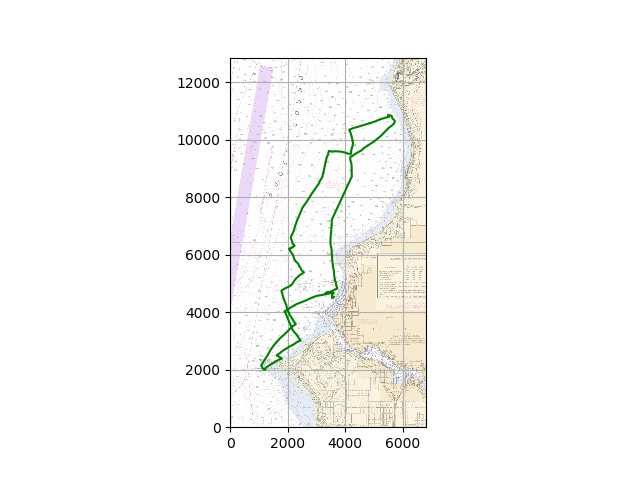

In [3]:
# mark to the finish
chart = c.plot_chart(df)
df = df.loc[example.begin : example.end]
c.draw_track(df, chart, color='green')

<IPython.core.display.Javascript object>


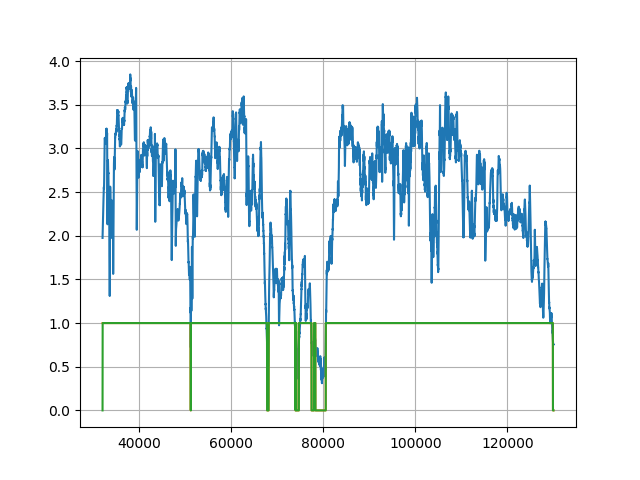

In [4]:
# Let's be sure the boat is moving for this analyis
is_moving = np.asarray(df.sog > 0.8)
is_mostly_moving = np.convolve(is_moving, np.ones(11), mode='same') > 6.0
c.quick_plot(df.index, (df.sog, is_moving, is_mostly_moving))

In [5]:
# Find the largest run where the boat is moving
runs = p.find_runs(is_mostly_moving)
sorted_runs = sorted(runs, key=lambda a: a[1] - a[0])
first, last = sorted_runs[-1]
print(f"Boat is moving consistently from {first} to {last}.")
if (last - first)/G.SAMPLES_PER_SECOND < (60 * 20):
    print(f"Warning that is not very long!")
    
sdf = df.iloc[(first + 1):(last - 1)].copy()

Boat is moving consistently from 48512 to 97880.


In [6]:
import importlib
importlib.reload(a)
importlib.reload(G)

<module 'global_variables' from '/Users/viola/GDriveBV/Sailboat/Code/Python/sailing/global_variables.py'>

## Comparing HDG with COG

Next step is to compare HDG with COG.

### Angles are annoying

One annoying fact of angles is that 355 degrees is actually quite close to 5 degrees, though the numeric difference is large.  One way around this is to **unwrap** the angles.  This is process where the angles are adjust by adding/subtracting 360 so that large steps in the signal are minimized.  

<IPython.core.display.Javascript object>


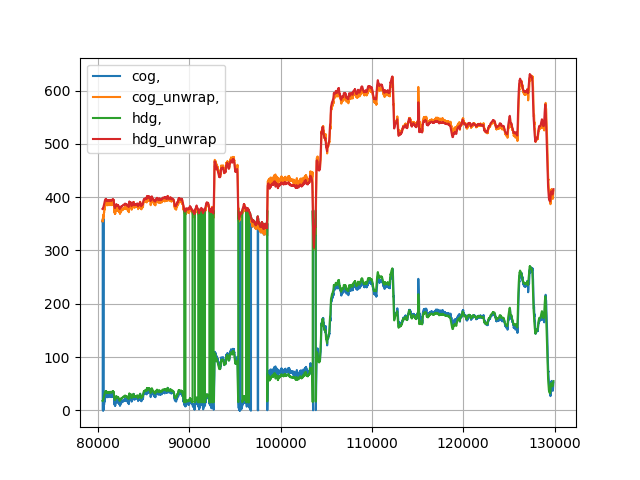

<IPython.core.display.Javascript object>


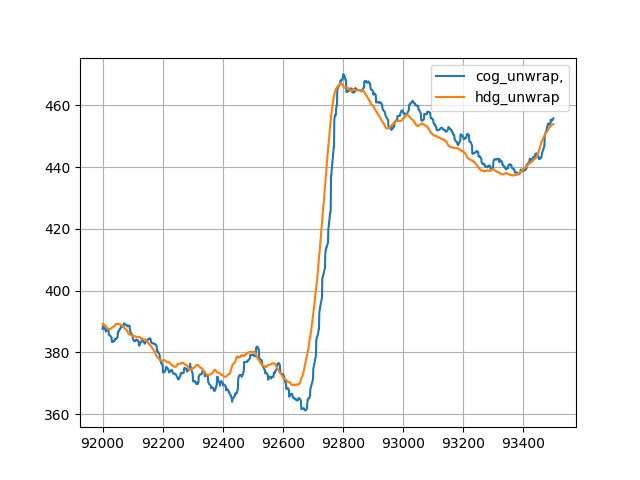

In [67]:
# Unwrap,  because these are angles
sdf['cog_unwrap'] = p.unwrap_d(sdf.rcog)
sdf['thdg'] = np.array(sdf.rhdg) + sdf.variation.mean()
sdf['thdg_unwrap'] = p.match_wrap_d(sdf.cog_unwrap, sdf.thdg)

c.quick_plot(sdf.index, (sdf.rcog, sdf.cog_unwrap, sdf.thdg, sdf.thdg_unwrap),
            "cog, cog_unwrap, hdg, hdg_unwrap".split())

start = 92000
wide_slice = slice(start, start + 1500)
wdf = sdf.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.cog_unwrap, wdf.thdg_unwrap),
            "cog_unwrap, hdg_unwrap".split())

## COG and HDG are quite close.

Notice above that COG and HDG are actually pretty close (as they should be).  But there are clearly places where they are different.  There are two good reasons for COG and HDG to differ: 

1. Current: the boat may be pushed by current in a different direction from its heading.
2. Leeway: when sailing upwind, all boats slip sideways slightly.

In addition, since HDG is a relative simple instrument (e.g. a compass) while GPS is quite complex, it is plausible that HDG measures a change in orientation before COG.

To compare these signals we will attempt to first normalize away the differences, and then find the delay that minimizes the remaining differences.

### High pass

Its reasonable to assume that changes in boat orientation show up in both signals, and the most frequent examples are tacks and jibes.  The actual angles measured between tacks and jibes may well be a bit different.  These constant offsets (or slowly varying offsets) can be eliminated by throwing out the low frequenciew (slowly changing stuff) and keeping the rapid changes.  This is called a [high pass filter](https://en.wikipedia.org/wiki/High-pass_filter).

We compute a high pass filter by first computing the low pass and then subtracting (... its one way to do it). 

The high pass rejects the absolute value of the signals (what some call DC) and leaves only the major wiggles.  This allows us to ignore that COG and HDG are affected by current (and can differ by 10 or more degrees). 

Note, this also removes any miscalibration (because of compass alignment).

**Notice how much more similar the high pass versions are.**

<IPython.core.display.Javascript object>


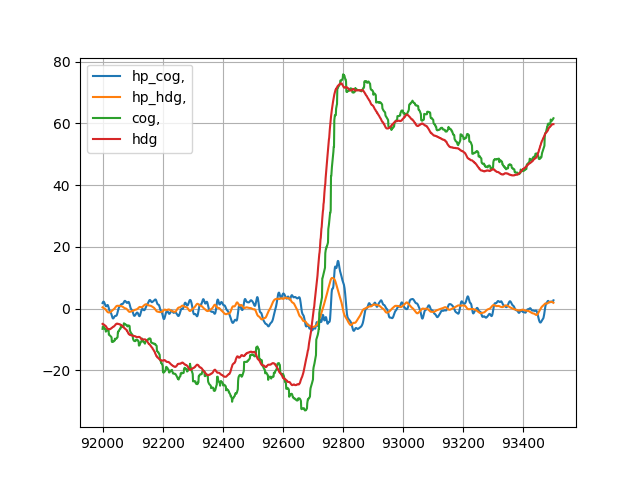

In [75]:
# Band-pass filter.  This gets rid of nuisance DC offsets and
# emphasizes regions of rapid change...  which are the only regions where delay is
# observable.
coeff = p.butterworth_bandpass(lowcut=0.05, highcut=1, order=5, )
sdf['hp_cog'] = hp_sig1 = p.smooth(coeff, sdf.cog_unwrap)
sdf['hp_hdg'] = hp_sig2 = p.smooth(coeff, sdf.thdg_unwrap)

wdf = sdf.loc[wide_slice]
mu = wdf.cog_unwrap.mean()-20
c.quick_plot(wdf.index, (wdf.hp_cog, wdf.hp_hdg, wdf.cog_unwrap-mu, wdf.thdg_unwrap-mu),
             "hp_cog, hp_hdg, cog, hdg".split())


## Normalizing the signals 

We can go further to normalize the signals so that they have the safe level of variability (this would allow you to compare signals that are similar but not identical).

<IPython.core.display.Javascript object>


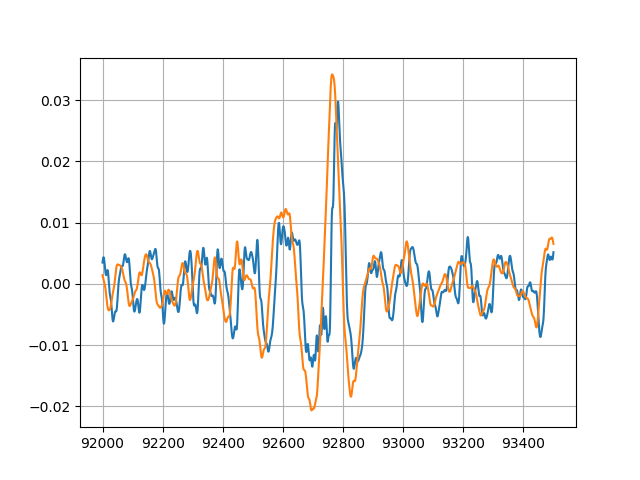

In [76]:
# Normalize (for correlation)
sdf = sdf
ncog = (sdf.hp_cog - sdf.hp_cog.mean()) / (np.std(sdf.hp_cog) * np.sqrt(len(sdf.hp_cog)))
nhdg = (sdf.hp_hdg - sdf.hp_hdg.mean()) / (np.std(sdf.hp_hdg) * np.sqrt(len(sdf.hp_hdg)))

sdf['ncog'] = ncog
sdf['nhdg'] = nhdg

wdf = sdf.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.ncog, wdf.nhdg))

## Find the right delay using correlation

We can now (finally) compare the COG to delayed versions of HDG, to find the best match.  This is done with the [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation).  See also [numpy.correlate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html).

The max correlation corresponds to the delay where the two signals have the highest match.

Found a delay of 17


<IPython.core.display.Javascript object>


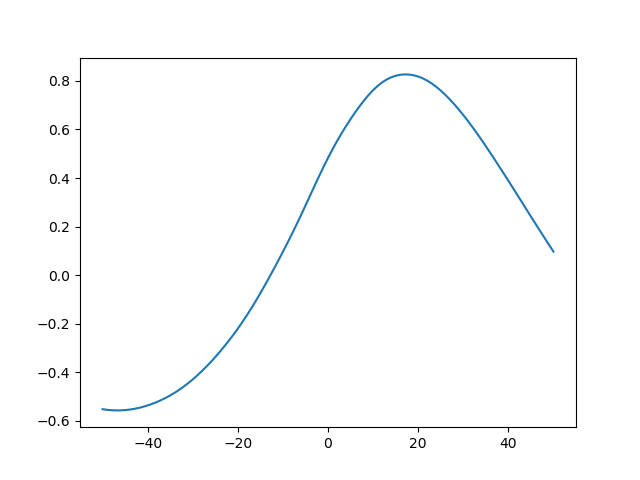

In [77]:
# Compute correlation (dot product) for various leads and lags
plus_minus_window = 50
res = np.correlate(ncog, nhdg[plus_minus_window:-plus_minus_window])
delay = np.argmax(res) - plus_minus_window
print(f"Found a delay of {delay}")

plt.figure()
plt.plot(range(-plus_minus_window, plus_minus_window+1), res)

<IPython.core.display.Javascript object>


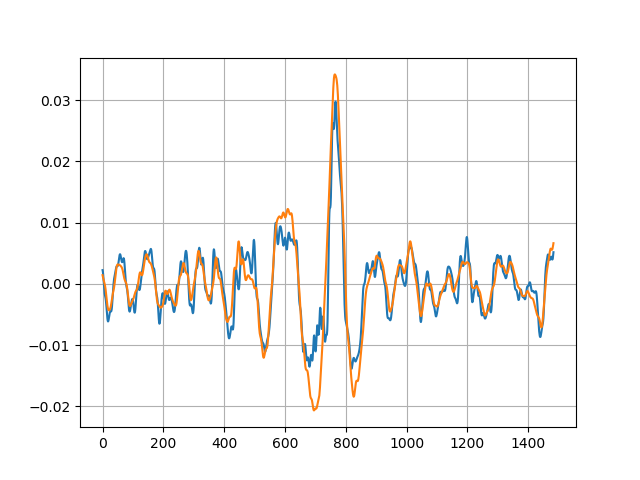

In [78]:
wcog = np.array(wdf.ncog)
whdg = np.array(wdf.nhdg)

c.quick_plot(None, (wcog[delay:], whdg[:-delay]))

In [12]:
logs_files = [log.log for log in G.SAIL_LOGS]
dfs, bdf = p.read_sail_logs(logs_files, path=G.DATA_DIRECTORY)

Session from 2019-10-04 23:43:46.050000, 78823 rows, 2.1894444444444443 hours.
Session from 2019-10-05 16:18:58.060000, 269392 rows, 7.482777777777778 hours.
Session from 2019-10-12 00:30:06.010000, 63268 rows, 1.7572222222222222 hours.
Session from 2019-10-12 16:45:44.050000, 233994 rows, 6.499444444444444 hours.
Session from 2019-10-18 20:51:17.030000, 32917 rows, 0.9141666666666667 hours.
... skipping, the boat does not move!
Session from 2019-10-19 16:45:36.080000, 262642 rows, 7.295555555555556 hours.
Session from 2019-10-26 16:40:01.010000, 104657 rows, 2.9072222222222224 hours.
Session from 2019-10-26 19:35:30.030000, 40291 rows, 1.1188888888888888 hours.
... skipping, the boat does not move!
Session from 2019-11-07 20:47:10.049000, 21247 rows, 0.59 hours.
... skipping, the boat does not move!
Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.
Session from 2019-11-23 18:23:07.080000, 96933 rows, 2.692222222222222 hours.
Session from 2019-11-24 18:33:

In [80]:
for df in dfs:
    if df is not None:
        delay, res = a.find_cog_delay(df, )
        print(f"Delay for {df.filename} is {delay}")

Delay for 2019-10-04_16:43.pd.gz is 17
Delay for 2019-10-05_09:18.pd.gz is 20
Delay for 2019-10-11_17:38.pd.gz is 17
Delay for 2019-10-12_09:45.pd.gz is 20
Delay for 2019-10-19_09:45.pd.gz is 21
Delay for 2019-10-26_09:40.pd.gz is 10
Delay for 2019-11-16_10:09.pd.gz is 19
Delay for 2019-11-23_10:23.pd.gz is 18
Delay for 2019-11-24_10:33.pd.gz is 19
Delay for 2019-12-07_09:47.pd.gz is 20
Delay for 2020-02-08_10:23.pd.gz is 17


## Delay estimating TWA

The TWA angle is computed on the boat using a combination of geometry and filtering.

The perception on the boat is that TWA is quite delayed relative to AWA (perhaps 5 or more seconds).

Note, TWA is not always logged (you need to have the autopilot on).  And I beleive we have adjusted the "damping" to various levels.

In [23]:
tw_df = [df for df in dfs if df is not None and 'twa' in df]
[df.filename for df in tw_df]

['2019-11-16_10:09.pd.gz',
 '2019-11-23_10:23.pd.gz',
 '2019-11-24_10:33.pd.gz',
 '2019-12-07_09:47.pd.gz',
 '2020-02-08_10:23.pd.gz']

<IPython.core.display.Javascript object>


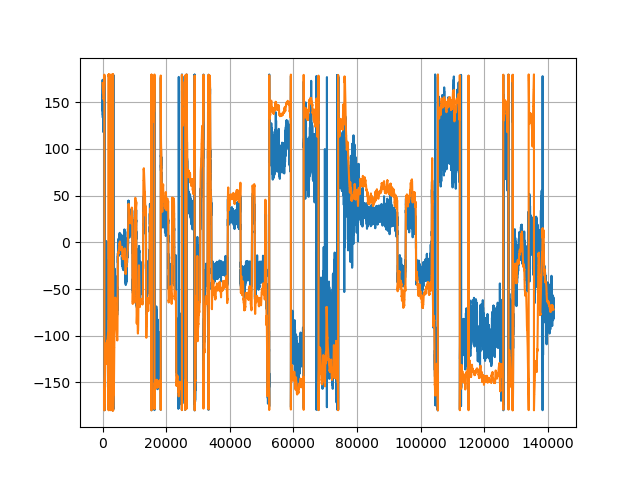

In [24]:
df = tw_df[-1]
c.quick_plot(df.index, (df.rawa, df.rtwa))

In [79]:
importlib.reload(p)
importlib.reload(a)


<module 'analysis' from '/Users/viola/GDriveBV/Sailboat/Code/Python/sailing/analysis.py'>

<IPython.core.display.Javascript object>


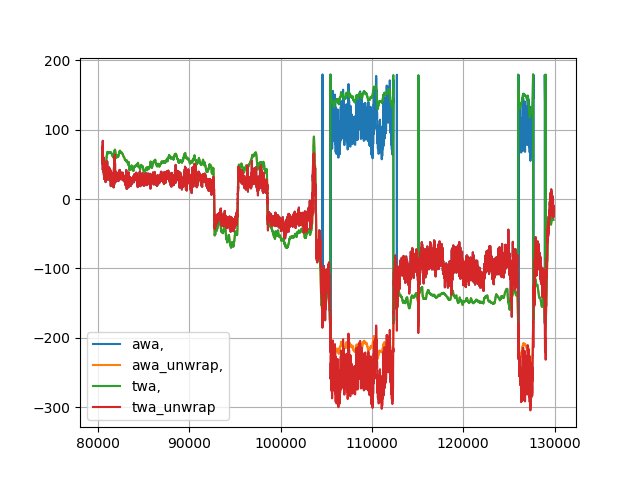

<IPython.core.display.Javascript object>


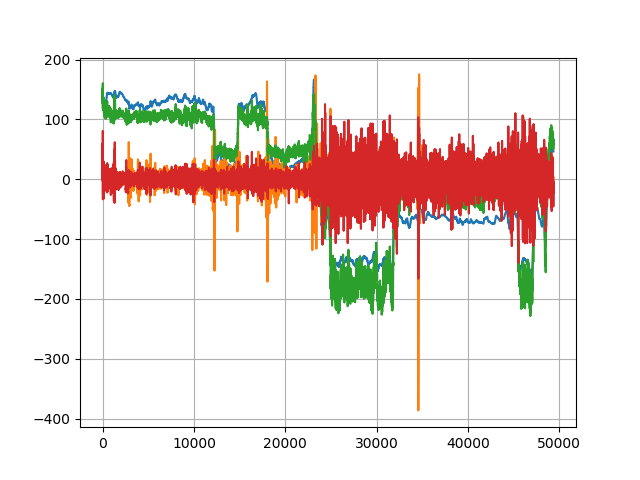

Delay for 2019-11-16_10:09.pd.gz is 0.7
Delay for 2019-11-23_10:23.pd.gz is 0.6
Delay for 2019-11-24_10:33.pd.gz is 0.7
Delay for 2019-12-07_09:47.pd.gz is 0.7
Delay for 2020-02-08_10:23.pd.gz is 0.5


In [66]:
delay, res = a.find_twa_delay(df, graph=True)
for df in tw_df:
    if df is not None:
        delay, res = a.find_twa_delay(df, )
        print(f"Delay for {df.filename} is {delay/10.0}")

## Delay for TWA is surprsingly low!

As we explored in [Boat Instruments](Boat_Instruments.ipynb),  the calculation of TWA/TWD/TWS is actually quite clever, and in some cases it can **lead** changes in AWA. 

In [1]:
df

NameError: name 'df' is not defined

In [2]:
dfs

NameError: name 'dfs' is not defined

In [6]:
df.columns

Index(['rsog', 'latitude', 'longitude', 'rhdg', 'row_seconds', 'rudder',
       'turn_rate', 'rtwd', 'rtws', 'rtwa', 'altitude', 'geoidal_separation',
       'variation', 'zg100_pitch', 'zg100_roll', 'raws', 'rawa', 'zeus_cog',
       'zeus_sog', 'zeus_altitude', 'zeus_gnss_type', 'rspd', 'depth', 'rcog',
       'timestamp', 'awa', 'aws', 'twa', 'tws', 'twd', 'spd', 'hdg', 'sog',
       'cog', 'row_times'],
      dtype='object')

In [29]:
tdf = df["row_times latitude longitude awa aws hdg spd sog cog".split()].loc[1005:1020]
tdf.row_times = tdf.row_times.dt.strftime('%r')
tdf

,row_times,latitude,longitude,awa,aws,hdg,spd,sog,cog
1005,10:25:08 AM,47.683,-122.405,-85.837,0.854,279.040,1.437,1.551,290.598
1006,10:25:09 AM,47.683,-122.405,-86.364,0.892,279.065,1.438,1.555,290.655
1007,10:25:09 AM,47.683,-122.405,-86.861,0.927,279.087,1.440,1.558,290.731
1008,10:25:09 AM,47.683,-122.405,-87.321,0.958,279.105,1.441,1.561,290.825
1009,10:25:09 AM,47.683,-122.405,-87.741,0.986,279.121,1.442,1.565,290.934
1010,10:25:09 AM,47.683,-122.405,-88.115,1.010,279.134,1.444,1.568,291.056
1011,10:25:09 AM,47.683,-122.405,-88.439,1.028,279.143,1.445,1.572,291.188
1012,10:25:09 AM,47.683,-122.405,-88.707,1.041,279.151,1.447,1.575,291.327
1013,10:25:09 AM,47.683,-122.405,-88.915,1.049,279.155,1.449,1.579,291.471
1014,10:25:09 AM,47.683,-122.405,-89.057,1.051,279.157,1.451,1.582,291.618


In [30]:
tdf.to_pickle(os.path.join(G.DATA_DIRECTORY, "basic_example.pd"))

In [25]:
import os